In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Image Based Sports Classification

## Library Imports

In [2]:
# usual imports
import pandas as pd
import numpy as np

# handle os specific
import os

# randomization
import random

# visualization imports 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

# consistent plot size
from pylab import rcParams
rcParams['figure.figsize'] = 17,7
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['axes.titlesize'] = 16
 
# ignore deprecated and future warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

## Setting Directory Paths

In [3]:
# check the root dir
os.listdir('/kaggle/input')

['logical-rythm-2k20-sports-image-classification']

In [4]:
# set the path
ROOT_DIR = '/kaggle/input'
FILE_PATH = os.path.join(ROOT_DIR,'logical-rythm-2k20-sports-image-classification')

In [5]:
# LIST DIRCTORIES INSIDE THE FILE PATH
os.listdir(FILE_PATH)

['train_labels.csv',
 'train',
 'test_images_list.csv',
 'test',
 'sample_submission.csv']

There are two directories - train and test. Rest are all the csv files. Lets explore the train directory. Data dir indicated there are no sub folders and all images are in the same directory. 

In [6]:
# SET THE TRAINING AND THE TEST PATH
TRAIN_PATH = os.path.join(FILE_PATH,'train')
TEST_PATH = os.path.join(FILE_PATH,'test')

In [7]:
os.listdir(TRAIN_PATH)

['train']

In [8]:
os.listdir(TEST_PATH)

['test']

In [9]:
TRAIN_IMAGES = os.path.join(TRAIN_PATH,'train')
TEST_IMAGES = os.path.join(TEST_PATH,'test')

In [10]:
len(os.listdir(TRAIN_IMAGES))

11040

In [11]:
len(os.listdir(TEST_IMAGES))

2760

In [12]:
# READ THE TRAIN csv FILE CONTAINING THE SPORTS LABEL
train_df = pd.read_csv(os.path.join(FILE_PATH,'train_labels.csv'))

In [13]:
# READ THE test csv FILE
test_df = pd.read_csv(os.path.join(FILE_PATH,'test_images_list.csv'))
test_df.tail()

,image
2755,./test/2755.jpg
2756,./test/2756.jpg
2757,./test/2757.jpg
2758,./test/2758.jpg
2759,./test/2759.jpg


In [14]:
# LIST THE FIRST FEW ROWS
train_df.head(10)

,image,sports
0,./train/0.jpg,baseball
1,./train/1.jpg,formula1
2,./train/2.jpg,fencing
3,./train/3.jpg,motogp
4,./train/4.jpg,ice_hockey
5,./train/5.jpg,wrestling
6,./train/6.jpg,motogp
7,./train/7.jpg,boxing
8,./train/8.jpg,volleyball
9,./train/9.jpg,volleyball


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11040 entries, 0 to 11039
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   11040 non-null  object
 1   sports  11040 non-null  object
dtypes: object(2)
memory usage: 172.6+ KB


In [16]:
len(train_df['sports'].unique())

22

### Summary based on data directory organization
- Images are organized in train and test dir
- All the train images are in the same directory and not in directories of their respective class. 
- There are 22 sports covered by the various images
- The dataframe has the full filename with the extension. 
- There are over 11,000 images in the training folder and roughly 2,700 images in the test folder

Important Consideration
-  Later I wanted to use the data augmentation using ImageDataGenerator class in Keras. Instead of flowfrom directory, I will need to use flow from dataframe.

## Data Exploration
- Display images and corresponding labels
- Check whether the data balanced --- > total image representation of various sports 
- Image sizes -- > to determine the input shape later in the model
- Variation in a particular sport's images

In [17]:
# Extract the unique labels
sports_labels = train_df['sports'].unique()

In [18]:
# LIST THE SPORTS NAME INCLUDED IN THE DATASET
sports_labels

array(['baseball', 'formula1', 'fencing', 'motogp', 'ice_hockey',
       'wrestling', 'boxing', 'volleyball', 'cricket', 'basketball',
       'wwe', 'swimming', 'weight_lifting', 'gymnastics', 'tennis',
       'kabaddi', 'badminton', 'football', 'table_tennis', 'hockey',
       'shooting', 'chess'], dtype=object)

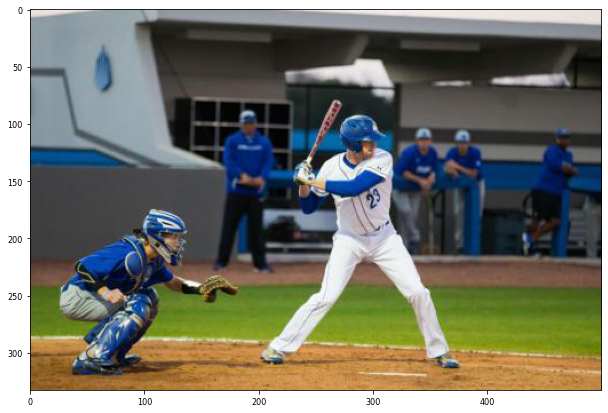

In [19]:
# CHECK ONE OF THE IMAGES -- > LETS PICK THE FIRST IN THE LIST
plt.imshow(imread(os.path.join(TRAIN_IMAGES,'0.jpg')));

In [20]:
# CHECK THE CLASS NAME OF THE DISPLAYED SPORT
train_df['sports'][0]

'baseball'

In [21]:
# IMAGE COUNT PER SPORT
train_df['sports'].value_counts()

badminton         698
football          611
volleyball        565
ice_hockey        559
baseball          555
tennis            555
boxing            542
formula1          539
swimming          531
gymnastics        531
table_tennis      530
motogp            513
wwe               508
cricket           501
fencing           494
weight_lifting    450
wrestling         432
shooting          417
hockey            405
basketball        375
chess             375
kabaddi           354
Name: sports, dtype: int64

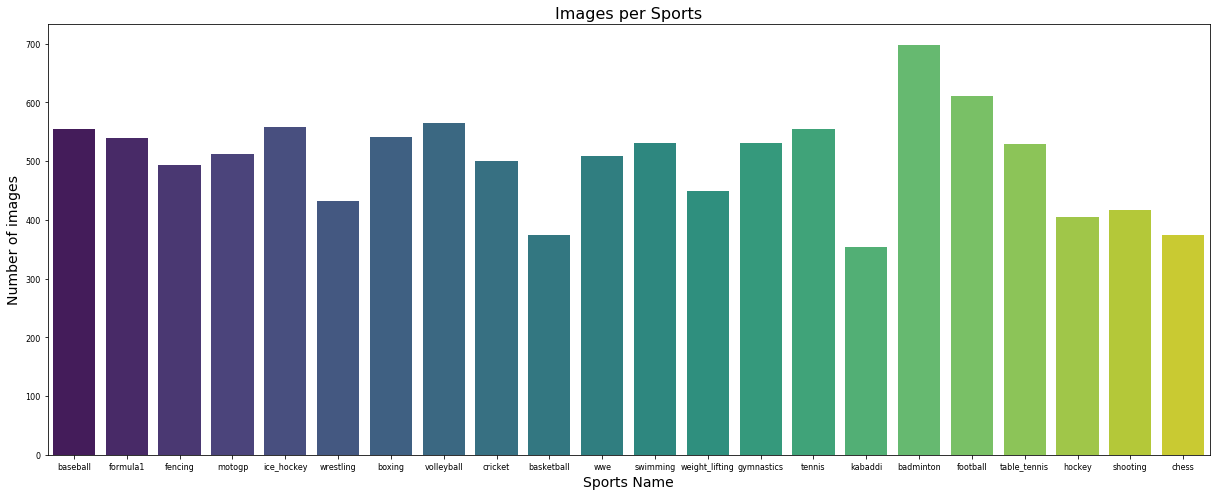

In [22]:
# VISUALIZE IMAGE COUNT PER SPORT
sns.countplot(train_df['sports'],palette='viridis')
plt.title('Images per Sports',)
plt.ylabel('Number of images')
plt.xlabel('Sports Name')
plt.tight_layout()

**Badminton and Football has the maximum number of images in the dataset. Kabaddi is the least. Broadly, the data does not seem to be biased for a particular sport.**

**It would be interesting to see the variation in the images in the dataset for a particular sport. The final model should be agnostic or robust to these variations. 
Same sports images can be provided from innumerable venues, angles, lighting levels, different people playing the sports etc. These variations make this project interesting to explore !!**

### Check various images of the same sport

In the below section, I randomly picked a sport and its corresponding images. Same sport can have different type of images and the trained model should be robust for all the variations. 

In [23]:
# PICK A RANDOM SPORTS
x = random.randint(0,len(train_df['sports'].unique()))
random_sport = sports_labels[x]

sports_show = train_df[train_df['sports']==random_sport]
print(f'The selected sport to display various images is {random_sport.upper()}')
sports_show.head()

The selected sport to display various images is ICE_HOCKEY


,image,sports
4,./train/4.jpg,ice_hockey
11,./train/11.jpg,ice_hockey
16,./train/16.jpg,ice_hockey
19,./train/19.jpg,ice_hockey
40,./train/40.jpg,ice_hockey


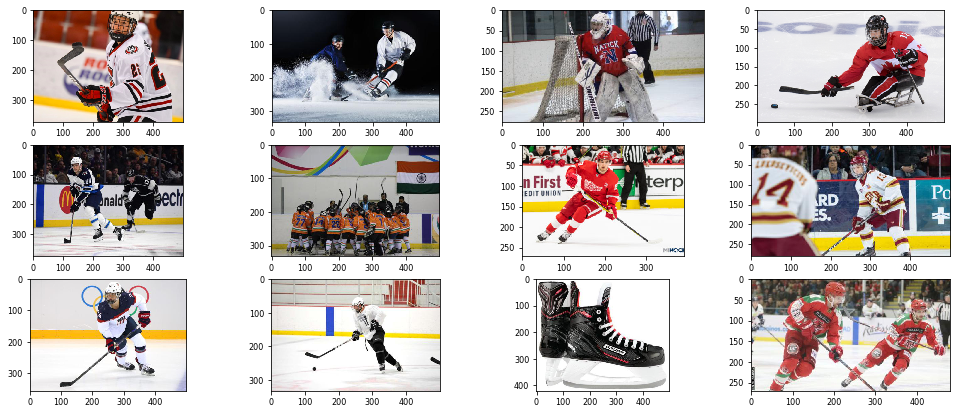

In [24]:
# DISPLAY THE SPORTS IMAGES --- > NOTICE THE VARIATION IN THE IMAGES OF THE SAME SPORT
n_rows = 3
n_cols = 4

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows,n_cols,index+1)
        # PICK RANDOM IMAGES OF THE SELECTED SPORT
        sport_img = random.randint(0,len(sports_show))
        image_ = plt.imread(os.path.join(TRAIN_IMAGES,sports_show.iloc[sport_img]['image'][8:]))
        # DISPLAY THE IMAGE
        plt.imshow(image_,cmap='binary',interpolation='nearest')
        #plt.axis('off')
        rcParams['axes.titlesize']= 12
        #plt.title(random_sport)  

The hello word of CNN is often the digit recognition in MNIST dataset. That itself has around 70,000 images and all the images are nicely centered. This makes even a fully connected model like ANN to come out with high accuracy. 

In the current situation of sports images, there are only 11,000 images covering 22 sports. Moreover, all the images are very different. Almost all as 3D with chances of grayscale as well (check out the hockey images if interested) and color images but have different colors, zoom ranges, light levels, images where only the equipment is present while others with the player on the field etc. 

So the task is not as easy as it appeared to me in the beginning. 

### Check the dimensions of the images
We do not know for sure the size/shape of the images. They all can be same or different. This needs to be determined so that it can be fed as a hyper-parameter in the image data generator. 

This might consume some time. Hence after the first run, better to comment this out. 

In [25]:
# RETRIEVE THE DIMENSION OF ALL THE TRAINING IMAGES
#dim1 = []
#dim2 = []

#for image in os.listdir(TRAIN_IMAGES):
 #   img = imread(os.path.join(TRAIN_IMAGES,image))
  #  d1,d2 = img.shape[0], img.shape[1]
   # dim1.append(d1)
    #dim2.append(d2)  

In [26]:
#print(f'Dimension 1 range is {np.min(dim1)} to {np.max(dim1)} and the range for dimension 2 is {np.min(dim2)} to {np.max(dim2)}')

Wonderful ! As if the image variation was not enough, the dimension of the images are all different. One way to tackle this is feed the mean of the image shape into the model. Other options could be to set it to max values. But this might result in slower training. 

In [27]:
# CHECK THE MODE OF THE DIMENSIONS
#from statistics import mode
#print (f'The most frequently occuring dimensions are {mode(dim1)} and {mode(dim2)}')

In [28]:
# TAKE THE MEAN OF THE DIMENSIONS OF THE IMAGES AND SET IT AS INPUT SHAPE, PLUS ANOTHER DIMENSION FOR COLOR
#IMAGE_SHAPE = (int(np.mean(dim1)),int(np.mean(dim2)),3)

In [29]:
IMAGE_SHAPE = (224,224,3)

Considering the mean and the mode, the IMAGE_SHAPE appears to be a good choice. 

## Data Preparation

All the images cannot be read into the memory at once. Secondly, the number of images per sports can be limited. Data augmentation technique is generally suited for this kind of problem. 

I will make use of the ImageDataGenerator class from Keras for this. I particularly liked this post 
https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

In [30]:
# IMPORT THE REQUIRED KERAS LIBRARIES FOR IMAGE AUGMENTATION
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
#help(ImageDataGenerator)

In [32]:
#from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.xception import preprocess_input

In [33]:
image_generator = ImageDataGenerator(    
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.5,
    zoom_range=[0.5,1.8],
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=preprocess_input,
    data_format=None,
    validation_split=0.2,
    dtype= 'float32'
)

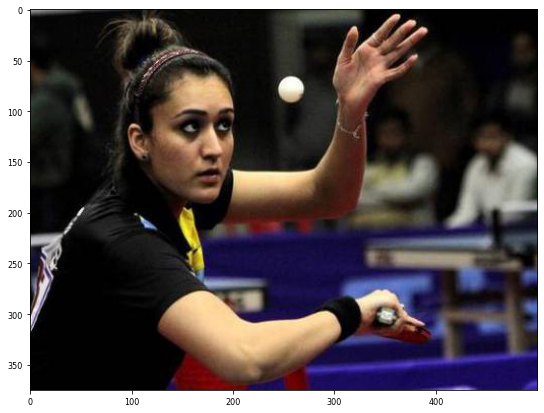

In [34]:
# DISPLAY THE ORIGINAL AND THE GENERATED IMAGES
image = imread(os.path.join(TRAIN_IMAGES,'129.jpg'))
plt.imshow(image)

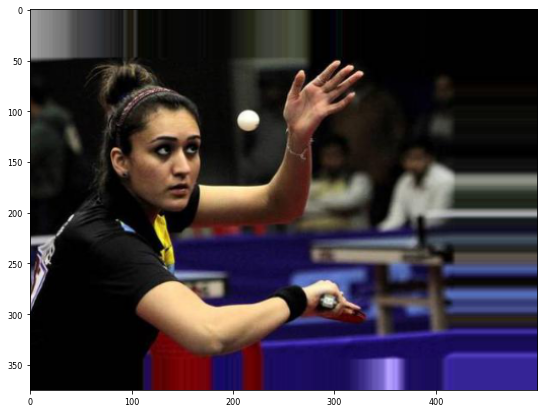

In [35]:
gen_image = image_generator.random_transform(image)
plt.imshow(gen_image)

### Generating many manipulated images from the directory

We need to use flow from dataframe instead of flow from directory as all the training images are in the single folder. 

### Create the training and validation generators. 

The directory path in the flow_from_dataframe should contain path till the point leading to the 'id' column in the dataframe. In this case, the id column is the column 'image' in the dataframe train_labels. The fields in the image column are labeled ./train/img_num.jpg eg ./train/0.jpg

Since I used the validation_split to split the dataset, I have to specify which set is to be used for which flow_from_dataframe function. The subset argument is set to “training” or “validation” accordingly. 

In [36]:
# DEFINE THE BATCH SIZE - --- > THIS IS USED AS AN INPUT WHILE FITTING THE MODEL USING GENERATORS
BATCH_SIZE = 32

In [37]:
# CREATE THE TRAINING GENERATOR 
train_generator = image_generator.flow_from_dataframe(dataframe=train_df,
                                                      directory=TRAIN_PATH,
                                                      x_col='image',
                                                      y_col='sports',
                                                      subset='training',
                                                      color_mode='rgb',
                                                      batch_size=BATCH_SIZE,
                                                      seed=42,
                                                      shuffle=True,
                                                      class_mode='categorical',
                                                      target_size=(224,224))

train_generator

Found 8832 validated image filenames belonging to 22 classes.


In [38]:
# CREATE THE VALIDATION GENERATOR 
validation_generator = image_generator.flow_from_dataframe(dataframe=train_df,
                                                           directory=TRAIN_PATH,
                                                           x_col='image',
                                                           y_col='sports',
                                                           subset='validation',
                                                           color_mode='rgb',
                                                           batch_size=BATCH_SIZE,
                                                           seed=42,
                                                           shuffle=False,
                                                           class_mode='categorical',
                                                           target_size=(224,224))

validation_generator

Found 2208 validated image filenames belonging to 22 classes.


In [39]:
# TEST GENERATOR ... NO SHUFFLE & CLASS MODE SET TO NONE
test_generator = image_generator.flow_from_dataframe(dataframe=test_df,
                                                     directory=TEST_PATH,
                                                     x_col='image',
                                                     y_col=None,
                                                     batch_size=BATCH_SIZE,
                                                     color_mode='rgb',
                                                     seed=42,
                                                     shuffle=False,
                                                     class_mode=None,
                                                     target_size=(224,224))

test_generator

Found 2760 validated image filenames.


## Build the Model

### Step 1: Experiment with a basic model

In [40]:
## IMPORT THE LIBRARIES
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPool2D,AvgPool2D,GlobalMaxPool2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger

In [41]:
trial = 4

In [42]:
if trial==1: # Basic Model
    
        
    ## DEFINE THE BASIC MODEL
    model =  Sequential()

    # ADD CONVOLUTIONAL LAYERS and MaxPooling Layer -- > Typical CNN Model
    model.add(Conv2D(filters=32,kernel_size=(7,7),input_shape=IMAGE_SHAPE,strides=1,padding='same',activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
        
    model.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
        
    model.add(Conv2D(filters=128,kernel_size=(3,3),strides=1,padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
        
    model.add(Conv2D(filters=256,kernel_size=(3,3),strides=1,padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
        
    # ADD DENSE LAYERS
    model.add(Flatten())
    model.add(Dense(units=512,activation='relu'))
    model.add(Dense(units=128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=22,activation='softmax'))
    
    
    # COMPILE THE BASIC MODEL 
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])  
       
    # PRINT MODEL SUMMARY
    print('BASIC MODEL')
    model.summary()
    
elif trial==2: # Batch Normalization plus selu actiovation and lecun-normal kernel initializer
    model = Sequential()
    
    # Add the CNN layers 
    model.add(Conv2D(filters=32,input_shape=IMAGE_SHAPE,padding='same',kernel_size=(3,3),activation='relu'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(filters=64,padding='same',kernel_size=(3,3),activation='relu'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(filters=128,padding='same',kernel_size=(3,3),activation='relu'))
    model.add(MaxPooling2D(2,2))
    
    # ADD THE DNN LAYERS
    model.add(Flatten())
    model.add(BatchNormalization())
    
    model.add(Dense(units=256,activation='selu',kernel_initializer='lecun_normal',use_bias=False))
    model.add(BatchNormalization())
    
    model.add(Dense(units=128,activation='selu',kernel_initializer='lecun_normal',use_bias=False))
    model.add(BatchNormalization())
    
    model.add(Dense(units=64,activation='selu',kernel_initializer='lecun_normal',use_bias=False))
    model.add(BatchNormalization())
    
    model.add(Dense(units=32,activation='selu',kernel_initializer='lecun_normal',use_bias=False))
    model.add(BatchNormalization())
    
    model.add(Dense(units=22,activation='softmax'))
    
    # COMPILE THE MODEL
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    print('Model with Batch Normalization')
    model.summary()
    
elif trial==3:    # VGG16 Pre Trained Model - SGD as well as Adam -- > Adam performs faster and returns better accuracy
    base_model = VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    # add new classification layers
    flat1 = Flatten()(base_model.layers[-1].output)
    class1 = Dense(512,activation='relu',kernel_initializer='he_normal')(flat1)
    class2 = Dense(256,activation='relu',kernel_initializer='he_normal')(class1)
    class3 = Dense(128,activation='relu',kernel_initializer='he_normal')(class2)
    output = Dense(22,activation='softmax')(class3)
    # define new model
    model = Model(inputs=base_model.inputs,outputs=output)
    #compile the model
    # opt = SGD(lr=0.001,momentum=0.9,nesterov=True)
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy')
    
    print('Transfer Learning based on VGG16')
    model.summary()
    
else:
    base_model = Xception(include_top=False,input_shape=(224,224,3),weights='imagenet')
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    # add new classification layers
    #avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
    flat1 = Flatten()(base_model.layers[-1].output)
    class1 = Dense(512,activation='relu',kernel_initializer='he_normal')(flat1)
    class2 = Dense(256,activation='relu',kernel_initializer='he_normal')(class1)
    class3 = Dense(128,activation='relu',kernel_initializer='he_normal')(class2)
    output = Dense(22,activation='softmax')(class3)
    # define new model
    model = Model(inputs=base_model.inputs,outputs=output)
    #compile the model
    # opt = SGD(lr=0.001,momentum=0.9,nesterov=True)
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy')
    
    print('Transfer Learning based on Xception Module')
    model.summary()  


83689472/83683744 [==============================] - 2s 0us/step
Transfer Learning based on Xception Module
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_

In [43]:
# DEFINE CALLBACKS ---- > EARLY STOP AND REDUCE LEARNING RATE ON PLATEAU
early_stop = EarlyStopping(patience=9,monitor='val_loss',restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(patience=2,monitor='val_loss',factor=0.1)
csv_logger = CSVLogger('epoch_run_transfer_Xception.csv',separator=',',append=True)

One of the hyperparatemer while training with the generators is the steps_per_epoch. The steps_per_epoch argument must specify the number of batches of samples comprising one epoch. If the original dataset has 10,000 images and your batch size is 32, then a reasonable value for steps_per_epoch when fitting a model on the augmented data might be ceil(10,000/32), or 313 batches. 
For more information, have a look at this article
https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

In [44]:
# DEFINE THE STEPS_PER_EPOCH
STEP_SIZE_TRAIN = (train_generator.n // train_generator.batch_size)   
STEP_SIZE_VALIDATION = (validation_generator.n // validation_generator.batch_size)   
STEP_SIZE_TEST = (test_generator.n // test_generator.batch_size) 

## Fit the Model

In [45]:
## FIT THE MODEL
model.fit_generator(generator=train_generator,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=validation_generator,
                   validation_steps=STEP_SIZE_VALIDATION,
                   epochs=30,
                   callbacks=[early_stop,csv_logger]
                   )

Epoch 1/30
276/276 [==============================] - 284s 1s/step - loss: 3.0259 - accuracy: 0.1051 - val_loss: 2.8975 - val_accuracy: 0.1481
Epoch 2/30
276/276 [==============================] - 172s 625ms/step - loss: 2.8353 - accuracy: 0.1410 - val_loss: 2.7732 - val_accuracy: 0.1562
Epoch 3/30
276/276 [==============================] - 173s 626ms/step - loss: 2.7451 - accuracy: 0.1740 - val_loss: 2.7548 - val_accuracy: 0.1884
Epoch 4/30
276/276 [==============================] - 171s 620ms/step - loss: 2.6789 - accuracy: 0.1908 - val_loss: 2.6623 - val_accuracy: 0.2020
Epoch 5/30
276/276 [==============================] - 169s 613ms/step - loss: 2.6411 - accuracy: 0.2092 - val_loss: 2.6085 - val_accuracy: 0.2101
Epoch 6/30
276/276 [==============================] - 170s 616ms/step - loss: 2.5819 - accuracy: 0.2209 - val_loss: 2.5955 - val_accuracy: 0.2296
Epoch 7/30
276/276 [==============================] - 165s 597ms/step - loss: 2.5570 - accuracy: 0.2283 - val_loss: 2.5446 - va

In [46]:
base_model.trainable = True
opt = Adam(lr=0.00001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy')


model.fit_generator(generator=train_generator,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=validation_generator,
                   validation_steps=STEP_SIZE_VALIDATION,
                   epochs=40,
                   callbacks=[early_stop,csv_logger]
                   )


Epoch 1/40
276/276 [==============================] - 220s 797ms/step - loss: 6.3616 - accuracy: 0.0725 - val_loss: 4.7096 - val_accuracy: 0.0616
Epoch 2/40
276/276 [==============================] - 225s 816ms/step - loss: 2.9204 - accuracy: 0.1469 - val_loss: 2.8312 - val_accuracy: 0.1834
Epoch 3/40
276/276 [==============================] - 236s 854ms/step - loss: 2.5369 - accuracy: 0.2537 - val_loss: 2.2483 - val_accuracy: 0.3284
Epoch 4/40
276/276 [==============================] - 238s 861ms/step - loss: 2.0349 - accuracy: 0.3888 - val_loss: 1.8337 - val_accuracy: 0.4447
Epoch 5/40
276/276 [==============================] - 235s 852ms/step - loss: 1.5881 - accuracy: 0.5230 - val_loss: 1.4729 - val_accuracy: 0.5503
Epoch 6/40
276/276 [==============================] - 235s 852ms/step - loss: 1.3129 - accuracy: 0.6093 - val_loss: 1.2201 - val_accuracy: 0.6449
Epoch 7/40
276/276 [==============================] - 277s 1s/step - loss: 1.1125 - accuracy: 0.6710 - val_loss: 1.0842 - va

In [47]:
# EVALUATE THE MODEL ... 
model.evaluate_generator(generator=validation_generator)

[0.5926257967948914, 0.8414855003356934]

In [48]:
#loss_df = pd.DataFrame(model.history.history)
#loss_df.plot()

## Prepare for final model

In [49]:
data_generator = ImageDataGenerator(    
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.5,
    zoom_range=[0.5,1.8],
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=preprocess_input,
    data_format=None,
    validation_split=0.0,
    dtype= 'float32'
) 
   

In [50]:
# CREATE THE TRAINING GENERATOR 
train_generator_full = data_generator.flow_from_dataframe(dataframe=train_df,
                                                      directory=TRAIN_PATH,
                                                      x_col='image',
                                                      y_col='sports',
                                                      subset='training',
                                                      color_mode='rgb',
                                                      batch_size=BATCH_SIZE,
                                                      seed=42,
                                                      shuffle=True,
                                                      class_mode='categorical',
                                                      target_size=(224,224))

train_generator_full

Found 11040 validated image filenames belonging to 22 classes.


In [51]:
model.fit_generator(generator=train_generator_full,
                   steps_per_epoch=train_generator_full.n//train_generator_full.batch_size,
                   epochs=35,
                   callbacks=[early_stop]
                   )

Epoch 1/35
345/345 [==============================] - 218s 631ms/step - loss: 0.2798 - accuracy: 0.9191
Epoch 2/35
345/345 [==============================] - 220s 637ms/step - loss: 0.2544 - accuracy: 0.9252
Epoch 3/35
345/345 [==============================] - 223s 646ms/step - loss: 0.2148 - accuracy: 0.9337
Epoch 4/35
345/345 [==============================] - 230s 665ms/step - loss: 0.2084 - accuracy: 0.9358
Epoch 5/35
345/345 [==============================] - 229s 664ms/step - loss: 0.1817 - accuracy: 0.9454
Epoch 6/35
345/345 [==============================] - 225s 651ms/step - loss: 0.1738 - accuracy: 0.9447
Epoch 7/35
345/345 [==============================] - 219s 634ms/step - loss: 0.1543 - accuracy: 0.9526
Epoch 8/35
345/345 [==============================] - 225s 652ms/step - loss: 0.1531 - accuracy: 0.9524
Epoch 9/35
345/345 [==============================] - 225s 652ms/step - loss: 0.1359 - accuracy: 0.9599
Epoch 10/35
345/345 [==============================] - 218s 633m

In [52]:
# RESET THE GENERATOR TO GET THE RESULTS IN THE RIGHT ORDER
test_generator.reset()


In [53]:
# GENERATE PREDICTIONS ON THE TEST DATA
predictions = model.predict_generator(test_generator)

In [54]:
# RETRIEVE THE CLASS INDEX FOR WHICH THE PROBABILITY IS MAXIMUM ...hence np.argmax
predictions_class_index = np.argmax(predictions,axis=1)

In [55]:
# CHECK THE PREDICTED CLASS INDICES
predictions_class_index

array([ 7, 13, 11, ..., 13, 17,  0])

In [56]:
# EXTRACT THE PREDICTION LABELS
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
final_predictions = [labels[k] for k in predictions_class_index]

In [57]:
# LIST THE FINAL PREDICTED LABELS
final_predictions

['football',
 'motogp',
 'ice_hockey',
 'table_tennis',
 'fencing',
 'chess',
 'hockey',
 'basketball',
 'motogp',
 'motogp',
 'football',
 'swimming',
 'cricket',
 'baseball',
 'cricket',
 'wwe',
 'ice_hockey',
 'swimming',
 'volleyball',
 'badminton',
 'football',
 'ice_hockey',
 'baseball',
 'table_tennis',
 'motogp',
 'gymnastics',
 'basketball',
 'boxing',
 'kabaddi',
 'wwe',
 'fencing',
 'shooting',
 'motogp',
 'badminton',
 'fencing',
 'volleyball',
 'formula1',
 'baseball',
 'kabaddi',
 'cricket',
 'chess',
 'volleyball',
 'basketball',
 'motogp',
 'boxing',
 'wrestling',
 'baseball',
 'volleyball',
 'kabaddi',
 'cricket',
 'table_tennis',
 'badminton',
 'weight_lifting',
 'wrestling',
 'fencing',
 'formula1',
 'football',
 'shooting',
 'boxing',
 'weight_lifting',
 'gymnastics',
 'boxing',
 'swimming',
 'hockey',
 'basketball',
 'cricket',
 'wwe',
 'football',
 'motogp',
 'chess',
 'wwe',
 'badminton',
 'basketball',
 'table_tennis',
 'swimming',
 'ice_hockey',
 'table_tennis'

In [58]:
len(final_predictions)

2760

In [59]:
# PREPARE FOR SUBMISSION
filenames=test_generator.filenames
results=pd.DataFrame({"image":filenames,
                      "sports":final_predictions})
results.to_csv("results.csv",index=False)

In [60]:
model.save('sports_xception_final_model_v2.h5')